# Flames - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard features used by the StellarAlgo retention model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 36 # flames

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(39050, 53)

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [4]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "clickToOpenRatio", 
    "clickToSendRatio",
    "distToVenue",
    "lkupClientId",
    "inperson_contact",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "year"
]

# choose the features & train year & test year
df = df[features]
df["year"] = pd.to_numeric(df["year"])

df_train = df.loc[df["year"] <= 2019]
df_train = df_train.sample(frac=0.95, random_state=786).reset_index(drop=True)

df_eval = df.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (31856, 17)
Unseen Data For Predictions: (7194, 17)



In [7]:
df_train.head()

,dimCustomerMasterId,attendancePercent,clickToOpenRatio,clickToSendRatio,distToVenue,inperson_contact,isNextYear_Buyer,missed_games_1,missed_games_2,missed_games_over_2,openToSendRatio,productGrouping,recency,renewedBeforeDays,source_tenure,totalSpent,year
0,138159,0.1250,0.000000,0.000000,16.35,0,1,0,0,4,0.000000,Full Season,24,153,7300,2408.44,2018
1,215977,1.0250,0.000000,0.000000,10.39,0,1,0,0,0,0.375000,Full Season,0,164,14235,11903.96,2017
2,275693945,0.2875,0.000000,0.000000,18.83,0,1,3,4,3,0.000000,Full Season,1,249,9855,15889.78,2016
3,300185,0.0000,0.000000,0.000000,21.96,0,1,0,0,1,0.000000,Full Season,0,249,7300,5674.28,2016
4,283533,0.7625,0.618182,0.149123,10.39,0,1,7,2,0,0.241228,Full Season,0,159,2190,2231.16,2018


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [8]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ]
);

In [10]:
model_matrix = compare_models(
    fold=10,
    exclude=["lda","qda"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9108,0.9321,0.9756,0.9041,0.9385,0.7776,0.7851,0.8910
xgboost,Extreme Gradient Boosting,0.9107,0.9305,0.9723,0.9063,0.9382,0.7781,0.7844,0.7440
gbc,Gradient Boosting Classifier,0.9034,0.9280,0.9757,0.8951,0.9336,0.7570,0.7667,0.3700
rf,Random Forest Classifier,0.9033,0.9243,0.9686,0.9002,0.9332,0.7593,0.7660,0.4080
ada,Ada Boost Classifier,0.8938,0.9204,0.9730,0.8858,0.9274,0.7314,0.7428,0.1340
et,Extra Trees Classifier,0.8856,0.9122,0.9475,0.8946,0.9203,0.7184,0.7221,0.3920
knn,K Neighbors Classifier,0.8575,0.8675,0.9351,0.8701,0.9014,0.6454,0.6510,0.2250
dt,Decision Tree Classifier,0.8536,0.8302,0.8898,0.8991,0.8944,0.6560,0.6561,0.0360
ridge,Ridge Classifier,0.7205,0.0000,0.8799,0.7579,0.8144,0.2613,0.2737,0.0240
lr,Logistic Regression,0.7126,0.7728,0.9332,0.7307,0.8187,0.1661,0.2107,0.9090


### The top model is performing well, so let's compare it against our unseen evaluation dataset:

In [11]:
best_model = create_model(model_matrix)
tuned_model = tune_model(best_model, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9090,0.9259,0.9769,0.9008,0.9373,0.7721,0.7807
1,0.9117,0.9322,0.9718,0.9079,0.9388,0.7811,0.7870
2,0.8972,0.9128,0.9685,0.8930,0.9292,0.7427,0.7509
3,0.9074,0.9272,0.9764,0.8994,0.9363,0.7680,0.7767
4,0.9125,0.9335,0.9752,0.9063,0.9395,0.7820,0.7889
5,0.9031,0.9277,0.9702,0.8988,0.9331,0.7580,0.7653
6,0.9105,0.9431,0.9741,0.9048,0.9382,0.7770,0.7840
7,0.9105,0.9380,0.9713,0.9069,0.9380,0.7781,0.7840
8,0.9109,0.9365,0.9673,0.9104,0.9380,0.7803,0.7849


### Let's plot the features to see what attributes were the most important to an accurate prediction

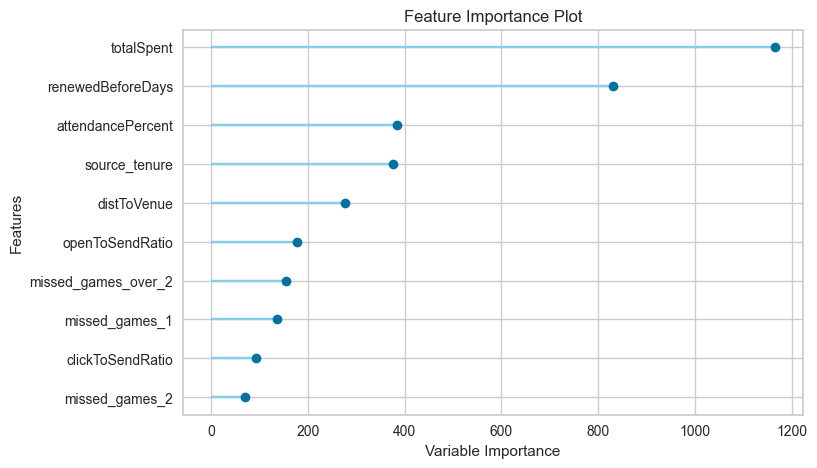

In [13]:
plot_model(tuned_model, plot='feature')

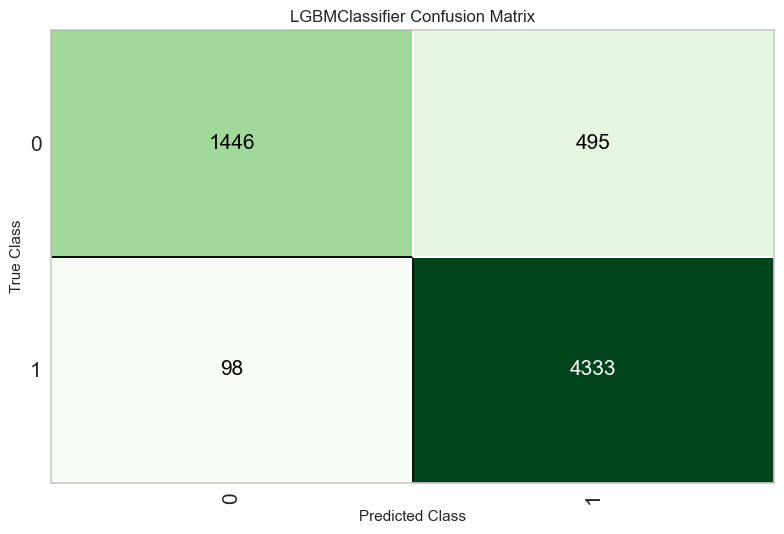

In [14]:
plot_model(tuned_model, plot='confusion_matrix')

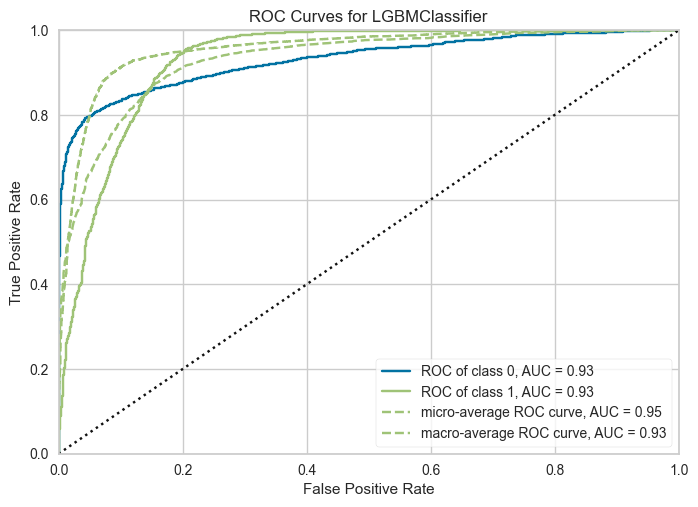

In [15]:
plot_model(tuned_model, plot='auc')

In [22]:
unseen_predictions = predict_model(tuned_model, raw_score=True)

unseen_predictions
print(unseen_predictions['Label'].value_counts())
unseen_predictions['Score_1'].value_counts(bins=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9069,0.9301,0.9779,0.8975,0.9360,0.7669,0.7764


1    4828
0    1544
Name: Label, dtype: int64


(0.742, 0.988]      4384
(0.00372, 0.251]    1327
(0.497, 0.742]       445
(0.251, 0.497]       216
Name: Score_1, dtype: int64

In [23]:
unseen_predictions.head()

,attendancePercent,clickToOpenRatio,clickToSendRatio,distToVenue,missed_games_1,missed_games_2,missed_games_over_2,openToSendRatio,recency,renewedBeforeDays,source_tenure,totalSpent,inperson_contact_0,isNextYear_Buyer,Label,Score_0,Score_1
0,0.1250,0.000000,0.000000,25.440001,0.0,0.0,3.0,0.000000,7.0,117.0,7300.0,5359.200195,1.0,0,0,0.9905,0.0095
1,0.9250,0.125000,0.176471,21.959999,4.0,0.0,0.0,1.411765,0.0,249.0,6205.0,5674.279785,1.0,1,1,0.0365,0.9635
2,0.3750,0.073171,0.027523,10.390000,4.0,3.0,3.0,0.376147,0.0,115.0,6205.0,12572.679688,1.0,1,1,0.1204,0.8796
3,0.0000,0.000000,0.000000,3.670000,0.0,0.0,1.0,0.000000,0.0,49.0,6205.0,816.320007,1.0,1,1,0.2978,0.7022
4,0.8625,0.000000,0.000000,5.260000,5.0,1.0,0.0,0.388889,0.0,141.0,6570.0,9116.919922,1.0,1,1,0.0478,0.9522


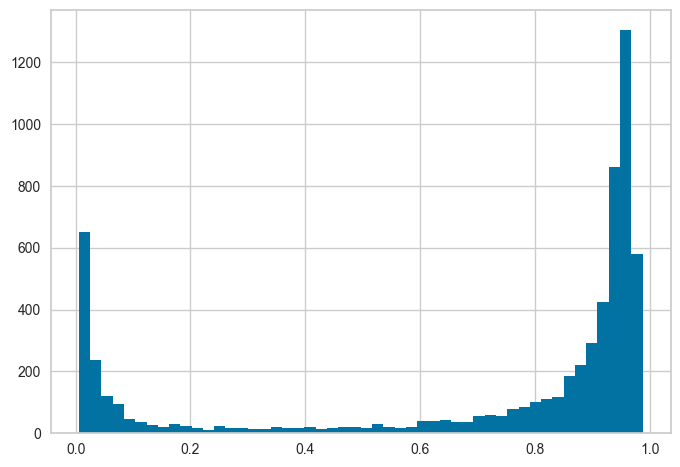

In [24]:
plt.hist(unseen_predictions["Score_1"], bins=50)

plt.show()